# Working with irregularly sampled data

In this example we will have a look at the [**HSAF Surface Soil Moisture NRT**][hsaf] product.

The product is hereby provided on a (non-rectangular) [spherical Fibonacci grid][fibgrid] and the data is stored in a [contiguous ragged array][cont_ragged] representation.

[hsaf]: https://hsaf.meteoam.it/Products/ProductsList?type=soil_moisture
[cont_ragged]: http://cfconventions.org/cf-conventions/cf-conventions.html#_contiguous_ragged_array_representation
[fibgrid]: https://arxiv.org/pdf/0912.4540

In [1]:
from pathlib import Path
import xarray as xar

from eomaps import Maps, widgets

In [2]:
%matplotlib qt
Maps.config(always_on_top=True)  # keep Qt figures "always on top"

In [3]:
# get a list of all files
swath_files = list(Path("swath_data").iterdir())

In [4]:
ncfile = xar.open_dataset(swath_files[0])
ncfile

<xarray.Dataset> Size: 6MB
Dimensions:                            (obs: 47330)
Coordinates:
    latitude                           (obs) float64 379kB ...
    longitude                          (obs) float64 379kB ...
    time                               (obs) datetime64[ns] 379kB ...
Dimensions without coordinates: obs
Data variables: (12/18)
    location_id                        (obs) float64 379kB ...
    as_des_pass                        (obs) float32 189kB ...
    swath_indicator                    (obs) float32 189kB ...
    surface_soil_moisture              (obs) float64 379kB ...
    surface_soil_moisture_noise        (obs) float64 379kB ...
    backscatter40                      (obs) float64 379kB ...
    ...                                 ...
    surface_flag                       (obs) float32 189kB ...
    snow_cover_probability             (obs) float32 189kB ...
    frozen_soil_probability            (obs) float32 189kB ...
    wetland_fraction                   (obs) float32 189kB ...
    topographic_complexity             (obs) float32 189kB ...
    subsurface_scattering_probability  (obs) float32 189kB ...
Attributes: (12/19)
    product_name:            W_IT-HSAF-ROME,SAT,SSM-ASCAT-METOPC-12.5km-H121_...
    title:                   ASCAT surface soil moisture near real-time product
    summary:                 ASCAT surface soil moisture expressed in degree ...
    doi:                     unset
    keywords:                Metop-C ASCAT surface soil moisture
    history:                 original generated product
    ...                      ...
    sensing_start_time_utc:  2023-06-29 00:00:00.000
    sensing_end_time_utc:    2023-06-29 00:59:59.999
    references:              h-saf.eumetsat.int
    date_created_utc:        2024-02-19 09:57:53.294
    software_version:        warp_nrt 0.0.0
    conventions:             CF-1.10

In [5]:
ssm_df = ncfile[["location_id", "surface_soil_moisture"]].to_dataframe()
gdf = ssm_df.groupby(["location_id"]).mean()
gdf

,surface_soil_moisture,latitude,longitude,time
location_id,,,,
3.0,NaN,0.000104,-52.523292,2023-06-29 00:25:42.828999936
92.0,75.68,0.003216,-50.714296,2023-06-29 00:25:36.035000064
236.0,81.61,0.008250,-51.832316,2023-06-29 00:25:40.282000128
325.0,77.64,0.011361,-50.023316,2023-06-29 00:25:33.488000000
469.0,80.73,0.016395,-51.141340,2023-06-29 00:25:37.734000128
...,...,...,...,...
3299017.0,NaN,-0.034399,-52.360176,2023-06-29 00:25:41.981000192
3299250.0,74.15,-0.026254,-51.669196,2023-06-29 00:25:39.432999936
3299627.0,74.76,-0.013074,-52.096244,2023-06-29 00:25:41.131000064


## Visualize the data

In [6]:
m = Maps()
m.add_feature.preset("ocean")

In [7]:
m.set_data(gdf.dropna(), x="longitude", y="latitude", parameter="surface_soil_moisture", crs=4326)
m.set_shape.geod_circles(radius=6250)
m.plot_map(set_extent=False)
m.add_colorbar()

## Visualize multiple files

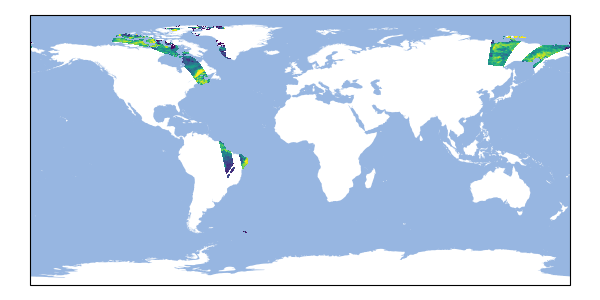

In [12]:
m = Maps(figsize=(6, 3))
m.add_feature.preset("ocean", layer="all")
m.set_shape.shade_points() # child maps will use the shape of the parent by default

def on_layer(m, filepath, parameter):
    with xar.open_dataset(filepath) as ncfile:
        ssm_df = ncfile[["location_id", parameter]].to_dataframe()
        data = ssm_df.groupby(["location_id"]).mean()
        
    m.set_data(data, "longitude", "latitude", parameter=parameter, crs=4326)
    m.plot_map(set_extent=False, cmap="viridis", vmin=0, vmax=100)

for filepath in swath_files:
    m.on_layer_activation(on_layer, layer=filepath.stem, filepath=filepath, parameter="surface_soil_moisture")

m.show_layer(swath_files[0].stem)
m.show()

In [9]:
widgets.LayerSelectionSlider(m, layers=sorted([i.stem for i in swath_files]), layout=dict(width="90%"))

LayerSelectionSlider(description='Layers', layout=Layout(width='90%'), options=(('W_IT-HSAF-ROME,SAT,SSM-ASCAT…

In [10]:
widgets.LayerSelectMultiple(m, layers=sorted([i.stem for i in swath_files]), layout=dict(width="1000px", height="300px"))

LayerSelectMultiple(description='Layers', index=(0, 0), layout=Layout(height='300px', width='1000px'), options…